In [3]:
from IPython.core.display import HTML, Markdown, display

import numpy.random as npr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf
import pingouin as pg
import random

import ipywidgets as widgets

from rl_exp import *
# Enable plots inside the Jupyter Notebook
%matplotlib inline

# Lab: Reinforcement Learning (Part II)

Authored by *Todd Gureckis* and *Hillary Raab*
Aspects borrowed from [Computational Cognitive Modeling](https://brendenlake.github.io/CCM-site/) graduate course.

---

## Building and Artificial Agent that learns from reinforcement

The previous part of the lab you took part in a simple **reinforcement learning** experiment known as the multi-armed bandit.  In addition, we analyzed some of our data to understand how our patterns of choices related to the rewards.  In this part of the lab we are going to build an artificial agent that learns to perform the same task by itself.

This gives you some initial understanding of the field of computational cognitive science and computational modeling of human behavior.

## The mental steps in performing the multi-armed "bandit" task

When we build a model we often have to think about the sequence of steps that are needed in order to perform a task.  What do you think those are for the multi-armed bandit?

<div class="alert alert-success" role="alert">
  <strong>Stop and think</strong> <br>
    Discuss with your neighbors/group for five minutes some of the ingredients you think might be needed in order to solve the task.  For example what information do you need to keep track of?  How do you make decisions about which arm of the bandit to choose?
</div>

## The environment

To get started, we need to define the RL environment for the agent.  Let's apply this agent to the same task you performed.  Read in your data file from the experiment phase using the following command:

In [6]:
rl_df = pd.read_csv("rlexp-XXX.csv")
rl_df.head()

,Unnamed: 0,subject,trial,block,choice,reward,best_resp,max,reward0,reward1,reward2,reward3,total_reward,rt
0,0,XXX,0,0,0,-0.457636,2,0,-0.457636,-0.210389,8.975787,0.093462,-0.457636,2095.666
1,1,XXX,1,1,1,-1.015812,2,0,4.647578,-1.015812,6.898189,-3.375761,-1.473447,268.223
2,2,XXX,2,2,0,1.699317,2,0,1.699317,-0.414074,4.219976,1.887663,0.225870,281.481
3,3,XXX,3,3,1,-2.582218,2,0,5.869208,-2.582218,5.883738,1.177207,-2.356349,398.100
4,4,XXX,4,4,2,1.674251,2,1,1.596461,-3.899903,1.674251,0.346435,-0.682098,163.687


Ok, in this data frame columns 'reward0', 'reward1', 'reward2', and 'reward3' define the amount of reward you *would* have gotten by selected each of the respective arms of the bandit.  As a result, we can use these rewards to test out our artificial agent.

## A basic agent

Let's begin by creating a very simple agent that randomly choose arms.  This bandit is going to be really simple and trivial.  It is the same as an agent that choose randomly with its eyes closed.  However, it is a useful starting point for coding smarter agents.

In [7]:
class RandomAgent():
    def __init__(self, k):
        self.num_actions = k
        # you could add parameters to your agent here
        pass
    
    def choose(self):
        return random.randrange(self.num_actions)
    
    def learn(self, reward, action): # this agent doesn't learn
        pass

Here we use a python 'class' which is an object-oriented framework for combining multiple functions and variables together.  Notice that the class definition starts with the name of the agent and then includes a few functions.  These functions are tabbed over so there are "within" the definition of the agent.  We can think of these functions as adding "powers" to our agent.  We have defined three functions.  The `__init__()` function is a special one.  It is a function that gets run when our agent is "created" or born.  Here it just intialized the number of available actions to k (k=4 in our experiment).  The other two functions are `choose()` and `learn()`.  These two functions allow us to make decisions and learn, respectively.

Right now our agent is really dumb.  In the learn function it just uses the `pass` keyword which means nothing happens.  So our agent is unable to learn.  The `choose` function is similarly dumb.  It randomly chooses an action from the available set.  Thus this agent is neither strategic nor able to learn.  Let's make it better!  

But first, let's see exactly how bad this little guy is!

In [26]:
# keep track of a few things
agent_choices = []
agent_rewards = []
agent_max = []

# create our random agent
dumbagent = RandomAgent(4)

# for each row in our original data
for idx, row in rl_df.iterrows():
    choice = dumbagent.choose() # have the agent choose
    reward = row[f'reward{choice}'] # get the reward for that choice
    max_r = choice==row['best_resp'] # is it the "maximizing" response?
    #track everything for analysis
    agent_choices.append(choice)
    agent_rewards.append(reward)
    agent_max.append(max_r)

# add new columns to the data frame similar to our human data 
# that are for the agent
rl_df['agent_choice'] =  agent_choices
rl_df['agent_reward'] =  agent_rewards
rl_df['agent_max'] =  agent_max

Great!  Now we have let our agent play the exact same game and we can compare the agent to how we performed!

Agent earned: 295.9213494013014 , Chose best response: 0.23809523809523808
Human earned: 751.5638874975159 , Chose best response: 0.5904761904761905


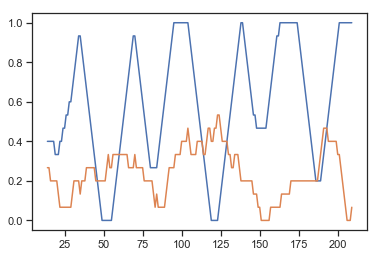

In [30]:
w=15
plt.plot(rl_df['max'].rolling(window=w).mean())
plt.plot(rl_df['agent_max'].rolling(window=w).mean())
print("Agent earned:", rl_df['agent_reward'].sum(), ", Chose best response:", rl_df['agent_max'].sum()/rl_df['agent_max'].count())
print("Human earned:", rl_df['reward'].sum(), ", Chose best response:", rl_df['max'].sum()/rl_df['max'].count())

Interesting!  The agent seemed to earn significant less and also chose the best response about 25% of the time.  That last part is expected (it chose randomly from four options).  However, the fact that it earned so much less reward than you is because it doesn't know how to learn or make smart decisions.

## A smarter agent

We would like to make our agent smarter.  One way is to keep track of the rewards it has received from each option and to choose the arm of the bandit with the most total reward

In [82]:
class SmarterAgent():
    def __init__(self, k):
        self.num_actions = k
        self.reward_history = [[0], [0], [0], [0]]
        pass
    
    def choose(self):
        reward_avg = np.array([np.mean(i) for i in self.reward_history])
        max_reward=npr.choice(np.flatnonzero(reward_avg == reward_avg.max()))
        return max_reward
    
    def learn(self, reward, action): # this agent doesn't learn
        self.reward_history[action].append(reward)

In [83]:
# keep track of a few things
agent_choices = []
agent_rewards = []
agent_max = []

# create our random agent
agent = SmarterAgent(4)

# for each row in our original data
for idx, row in rl_df.iterrows():
    choice = agent.choose() # have the agent choose
    reward = row[f'reward{choice}'] # get the reward for that choice
    max_r = choice==row['best_resp'] # is it the "maximizing" response?
    
    # NOW THE AGENT LEARNS!!!
    agent.learn(reward, choice)
    #track everything for analysis
    agent_choices.append(choice)
    agent_rewards.append(reward)
    agent_max.append(max_r)

# add new columns to the data frame similar to our human data 
# that are for the agent
rl_df['agent_choice'] =  agent_choices
rl_df['agent_reward'] =  agent_rewards
rl_df['agent_max'] =  agent_max

<div class="alert alert-info" role="alert">
<h3> Problem 1</h3><br>
Based on the way we analyzed the behavior of the RandomAgent, make a similar plot for the SmarterAgent.  How does it do?  Why do you think the outputs look like the do.  Write a few sentences describing your obsrvations.
</div>

## Exploring to Learn

The SmarterAgent we just considered keeps track of the average reward from each bandit arm in a list.  However, it always **chooses** the best action so far.  What is wrong with this strategy?

<div class="alert alert-success" role="alert">
  <strong>Stop and think</strong> <br>
    Discuss with your neighbors/group for five minutes what is wrong with this strategy.  Enter a markdown cell below with the notes from your discussion.
</div>

The agent would do better if we can inject some randomness into its decisions.  Not as much as the random agent but something close.  One common strategy for this in computer science is called Epislon-greedy or $\epsilon$-greedy.  Under this strategy, you choose the best action **most** of the time but with probability equal to $\epsilon$ (a small number) you chose randomly.  Thus, this agent would kind of combine elements of both the random and smarter agents.

<div class="alert alert-info" role="alert">
<h3> Problem 2</h3><br>
Below I provided a template for a SmarterExploringAgent.  This agent is similar to the one above but I have deleted the choose function and will ask you to implement that decision rule.  Your code should use the parameter epsilon to decide to either choose randomly (see RandomAgent) or choose the best option with the highest average reward (like SmarterAgent).  After you implement it run it on the problem and see how it does.  Remember you will need to provide the epsilon parameter to the choose() function in your code.  You should make this number relatively small (like 0.01) but you can play with different numbers.</div>

In [88]:
class SmarterExploringAgent():
    def __init__(self, k):
        self.num_actions = k
        self.reward_history = [[0], [0], [0], [0]]
        pass
    
    def choose(self, epsilon):
        
        pass
    
    def learn(self, reward, action): # this agent doesn't learn
        self.reward_history[action].append(reward)

## Learning incrementally

The agent we have made learns but it does this in a somewhat unrealistic way.  We could say it has a **memory** for every past reward it has recieved and each time it makes a choice it computes the average of those experiences.  As the amount of trials in the experiment (or episodes in life) increase, this agent will have to grow a really large memory and possibly it won't fit in the computer anymore.  This seems unrealistic compared to how we solved the problem, right?

But there is still *another* problem with this approach.  Your Smarter agent probably still didn't do that well because it has TOO much memory...  These bandits are changing how good they are from time to time and this bandit tracks the overall average.  This means it'll still be averaging together values from the past even when things change.  It is like even after your favorite restaurant becomes bad you still use the good experiences you had long ago to make your decision today.  The best thing to do sometimes is to forget the past and move on!

A common solution to this is to track the average *incrementally*.  Incremental tracking of an average can be done with much less memory.  To do this we will calculate something called the Q value for each bandit on every trial. The Q value can be estimated by taking the Q value on the previous trial and adding the prediction error, scaled by the learning rate. 

Okay, don't be scared, but let's write this out as a mathematical equation.
Again we have:
- the value of a particular machine: Q(s,a)
- the learning rate which can be written as alpha
- the prediction error

The preciction error is calculate by subtracting what you expected (the value of a particular machine) from the reinforcement, which we can define as r (always 1 for reward or 0 if there is no reweard).
Here is the prediction error equation: $[r - Q(s,a)]$


Then we can update the Q values in Q-learning as follows:

$Q(s,a) = Q(s,a) + \alpha [r - Q(s,a)] $

<div class="alert alert-info" role="alert">
<h3>Problem 3</h3><br>
Before we continue, let's get a little more experience with the prediction error. If you get a reward of 1, and the Q value is .6 (this is what you expect). Is this a positive or negative prediction error? What is the value of the prediction error?
</div>

<div class="alert alert-info" role="alert">
    Your answer here!
</div>

<div class="alert alert-info" role="alert">
<h3>Problem 4</h3><br>
Below I provided a template for a SmarterExploringIncrementalAgent. You should first implement the learn function.  I have provided the first bit of code to help you update the value of the chose q_value.  This should be 1 line of code and you are just putting the variables together like in the quation (self.q_values[action] = Q(s,a) in the equation, reward is r, and alpha is the alpha). Next you have to adapt the choice function from above to use the q-values.</div> 

In [ ]:
class SmarterExploringIncrementalAgent():
    def __init__(self, k):
        self.num_actions = k
        self.q_values = np.zeros(4)
        pass
    
    def choose(self, epsilon):
        # modify your choice rule from the previous agent to use the q_values
        pass
    
    def learn(self, reward, action, alpha): # this agent doesn't learn
        # replace this line here with the q-learning equation
        self.q_values[action] = reward

<div class="alert alert-info" role="alert">
<h3>Problem 5</h3><br>
Copy the code from above to apply this agent to the task and evaluate its performance.  How does it do?  How does learning change when you move around the learning rate? What happens when the learning rate is 0? What happens when the learning rate (alpha) is 1? What about as it approaches 0 or 1?
</div> 

<div class="alert alert-info" role="alert">Your answer here!</div>

<div class="alert alert-info" role="alert">
<h3>Problem 6</h3><br>
You created a bunch of agents in this exercise, each trying to be more and more similar to humans.  What aspect do you think these agents still lack compared to the way you solved the problem?
</div>

<div class="alert alert-info" role="alert">Your answer here!</div>